<a href="https://colab.research.google.com/github/dp913/CSE523_Machine_Learning_2023_Group-10/blob/master/Code/Big_Mart_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Libraries

In [3]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Read the Dataset

In [4]:
# loading the data to Pandas DataFrame
df_data = pd.read_csv('/content/train.csv')

In [5]:
# Showing the first five rows
df_data.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [6]:
# Number of data points and features
df_data.shape

(8523, 12)

In [7]:
# Infomation about the data
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


##Categorical Features:

- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier
- Outlet_Size
- Outlet_Location_Type
- Outlet_Type

##Numerical Features:

- Item_Weight
- Item_Visibility
- Item_MRP
- Outlet_Establishment_Year
- Item_Outlet_Sales

In [8]:
# Checking for missing values
df_data.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Replace missing values:

- Numerical feature --> Mean
- Categorical feature --> Mode

In [9]:
# Mean of "Item_Weight" feature
df_data['Item_Weight'].mean()

12.857645184135976

In [10]:
# filling the missing values in "Item_weight" column with Mean
df_data['Item_Weight'].fillna(df_data['Item_Weight'].mean(), inplace=True)

In [11]:
df_data.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [12]:
# mode of "Outlet_Size" column
df_data['Outlet_Size'].mode()

0    Medium
Name: Outlet_Size, dtype: object

In [13]:
# filling the missing values in "Outlet_Size" column with Mode
df_data['Outlet_Size'].fillna(df_data['Outlet_Size'].mode()[0],inplace=True)

In [14]:
df_data.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [15]:
df_data['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [16]:
df_data.replace({'Item_Fat_Content': {'low fat':'Low Fat','LF':'Low Fat', 'reg':'Regular'}}, inplace=True)

In [17]:
df_data['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

# Exploratory Data Analysis

### EDA using pandas profiling

In [96]:
!pip install pandas_profiling

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 21.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 83.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.8/679.8 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 67.6 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27096 sha256=24caf254cbfc2d65e4af723d6a349f3d00fffc3fd0449b

In [97]:
import pandas_profiling as pp

<ipython-input-97-4afb823491c5>:1: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


In [98]:
profile = pp.ProfileReport(df_data, title ="Pandas Profiling Report")

In [99]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

<ipython-input-22-ec7cfd9be39e>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_data.corr(),annot=True)


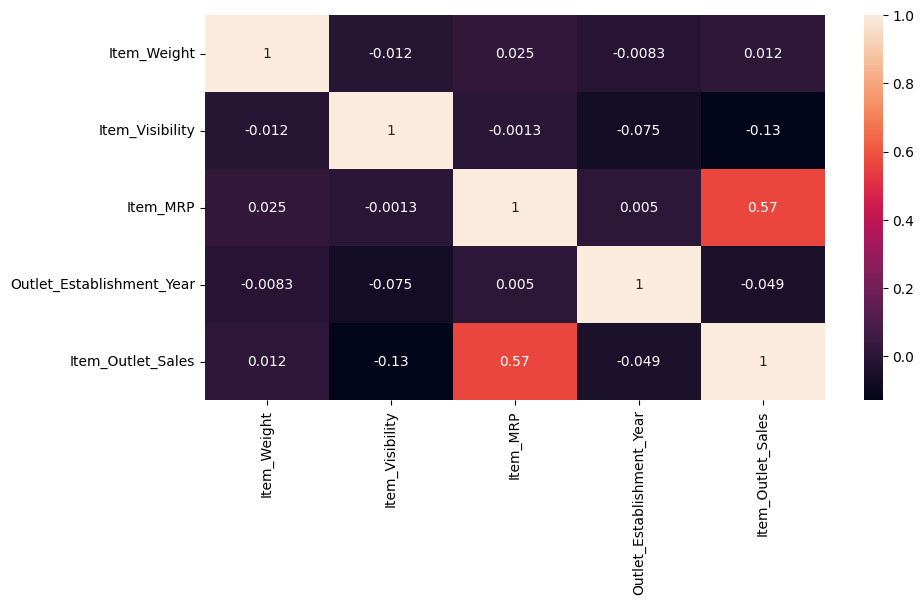

In [22]:
plt.figure(figsize=(10,5))
sns.heatmap(df_data.corr(),annot=True)
plt.show()

## EDA using Klib library

In [23]:
!pip install klib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import klib

GridSpec(6, 7)

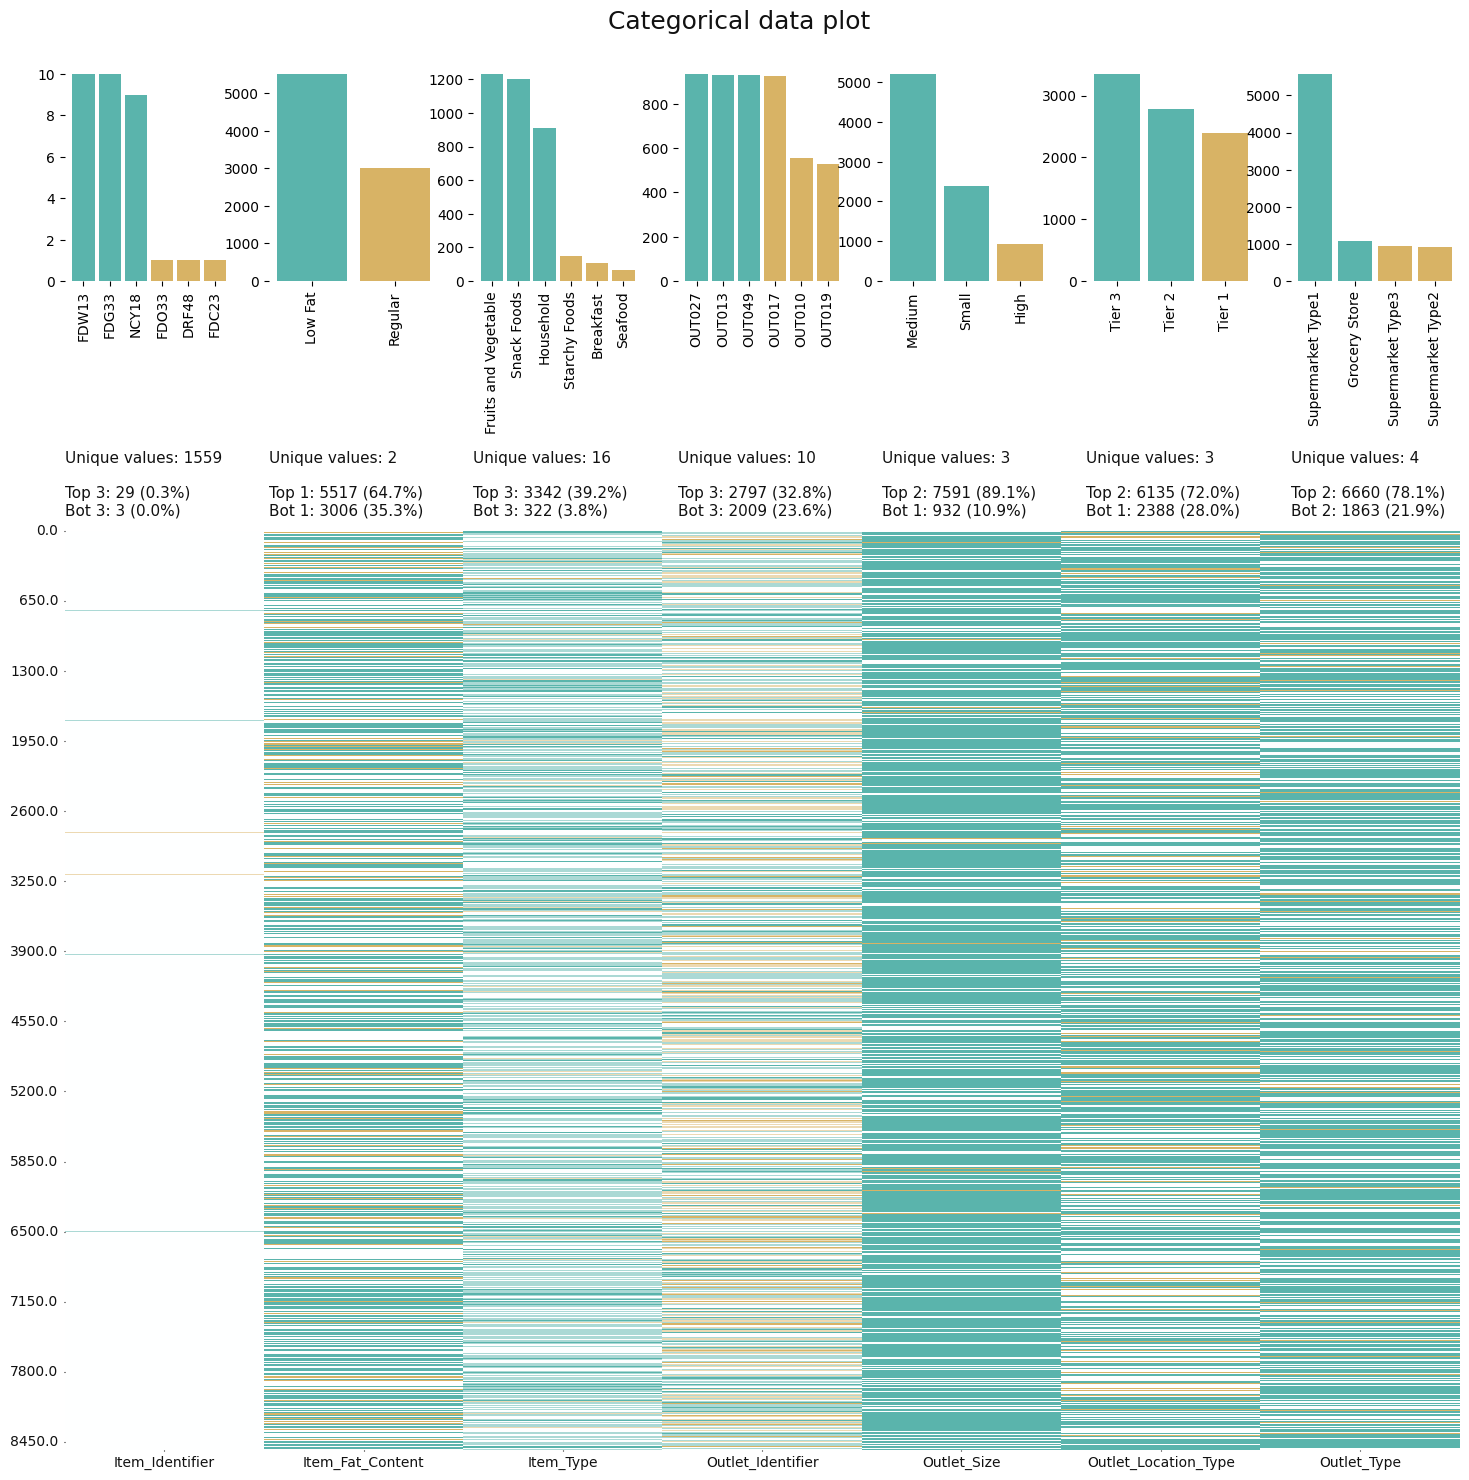

In [25]:
klib.cat_plot(df_data) # returns a visualization of the number and frequency of categorical features

<Axes: xlabel='Item_Outlet_Sales', ylabel='Density'>

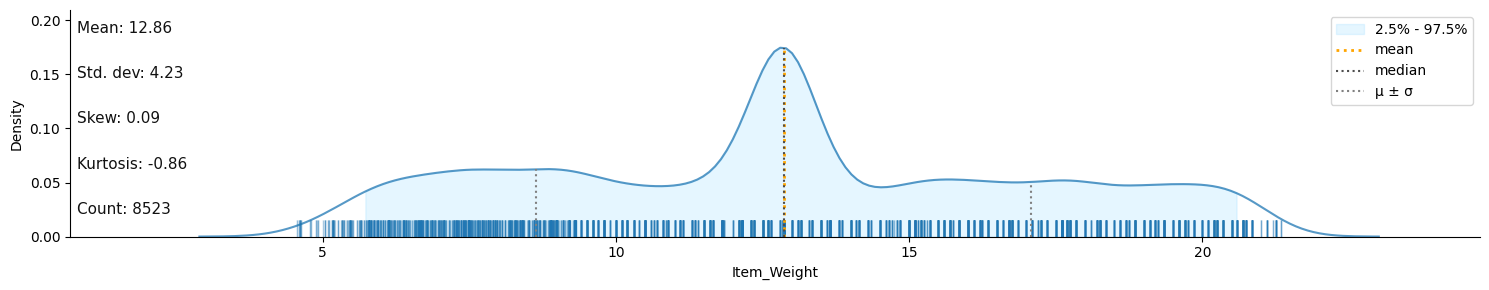

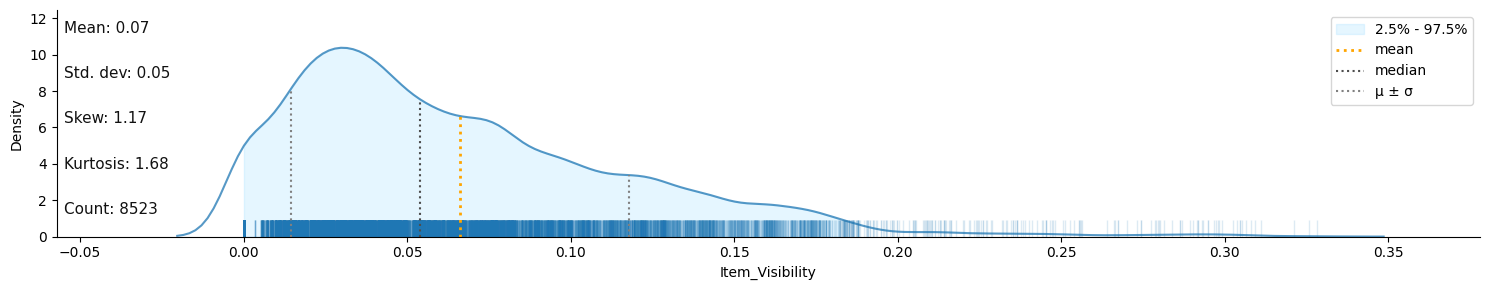

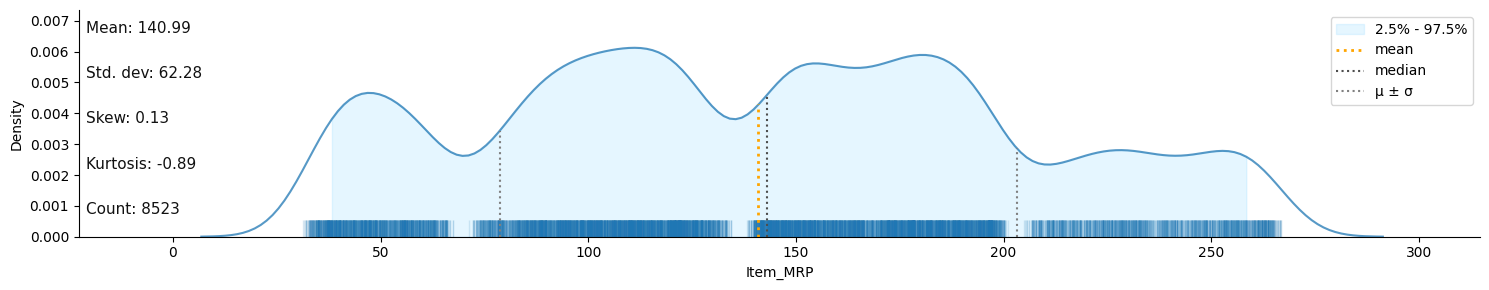

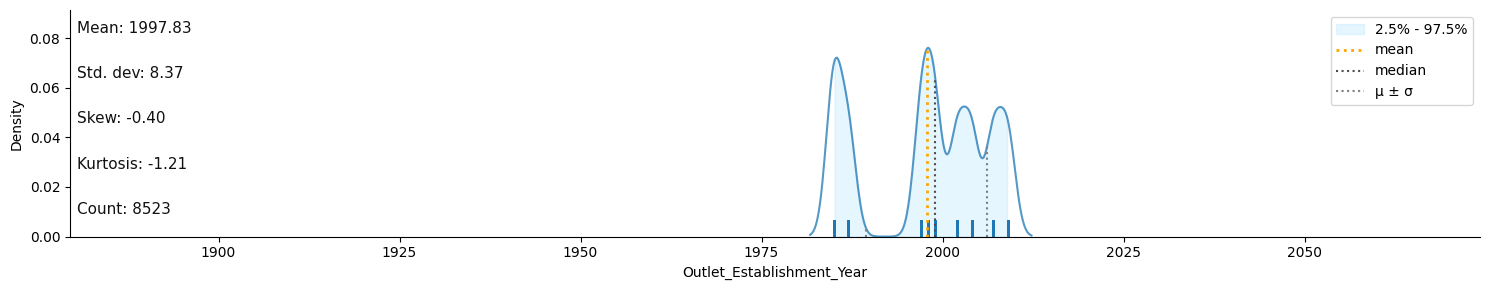

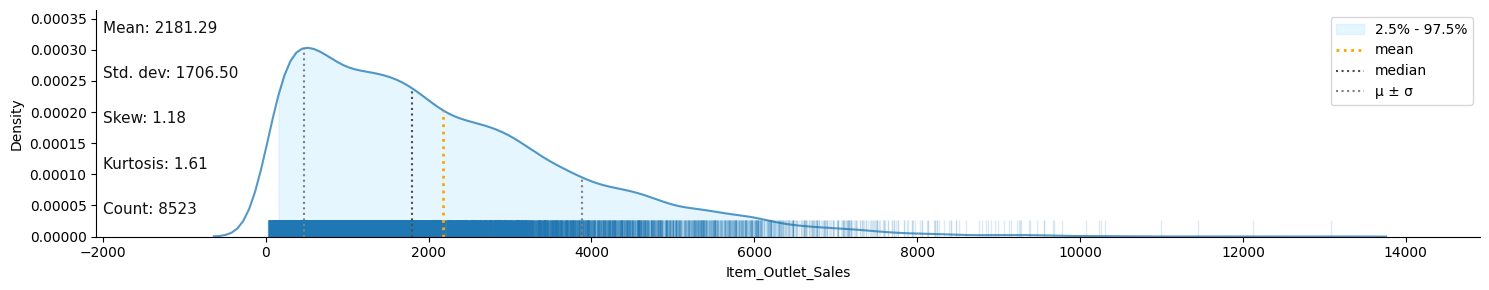

In [26]:
klib.dist_plot(df_data) # returns a distribution plot for every numeric feature

In [27]:
klib.data_cleaning(df_data) # performs datacleaning (drop duplicates & empty rows/cols, adjust dtypes,...)

Shape of cleaned data: (8523, 12) - Remaining NAs: 0


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 0
     of which 0 single valued.     Columns: []
Dropped missing values: 0
Reduced memory by at least: 0.52 MB (-66.67%)



item_identifier  item_weight item_fat_content  item_visibility  \
0              FDA15     9.300000          Low Fat         0.016047   
1              DRC01     5.920000          Regular         0.019278   
2              FDN15    17.500000          Low Fat         0.016760   
3              FDX07    19.200001          Regular         0.000000   
4              NCD19     8.930000          Low Fat         0.000000   
...              ...          ...              ...              ...   
8518           FDF22     6.865000          Low Fat         0.056783   
8519           FDS36     8.380000          Regular         0.046982   
8520           NCJ29    10.600000          Low Fat         0.035186   
8521           FDN46     7.210000          Regular         0.145221   
8522           DRG01    14.800000          Low Fat         0.044878   

                  item_type    item_mrp outlet_identifier  \
0                     Dairy  249.809204            OUT049   
1               Soft Drinks   48.269199            OUT018   
2                      Meat  141.617996            OUT049   
3     Fruits and Vegetables  182.095001            OUT010   
4                 Household   53.861401            OUT013   
...                     ...         ...               ...   
8518            Snack Foods  214.521805            OUT013   
8519           Baking Goods  108.156998            OUT045   
8520     Health and Hygiene   85.122398            OUT035   
8521            Snack Foods  103.133202            OUT018   
8522            Soft Drinks   75.467003            OUT046   

      outlet_establishment_year outlet_size outlet_location_type  \
0                          1999      Medium               Tier 1   
1                          2009      Medium               Tier 3   
2                          1999      Medium               Tier 1   
3                          1998      Medium               Tier 3   
4                          1987        High               Tier 3   
...                         ...         ...                  ...   
8518                       1987        High               Tier 3   
8519                       2002      Medium               Tier 2   
8520                       2004       Small               Tier 2   
8521                       2009      Medium               Tier 3   
8522                       1997       Small               Tier 1   

            outlet_type  item_outlet_sales  
0     Supermarket Type1        3735.137939  
1     Supermarket Type2         443.422791  
2     Supermarket Type1        2097.270020  
3         Grocery Store         732.380005  
4     Supermarket Type1         994.705200  
...                 ...                ...  
8518  Supermarket Type1        2778.383301  
8519  Supermarket Type1         549.284973  
8520  Supermarket Type1        1193.113647  
8521  Supermarket Type2        1845.597656  
8522  Supermarket Type1         765.669983  

[8523 rows x 12 columns]

In [28]:
klib.clean_column_names(df_data) # cleans and standardizes column names, also called inside data_cleaning()

item_identifier  item_weight item_fat_content  item_visibility  \
0              FDA15        9.300          Low Fat         0.016047   
1              DRC01        5.920          Regular         0.019278   
2              FDN15       17.500          Low Fat         0.016760   
3              FDX07       19.200          Regular         0.000000   
4              NCD19        8.930          Low Fat         0.000000   
...              ...          ...              ...              ...   
8518           FDF22        6.865          Low Fat         0.056783   
8519           FDS36        8.380          Regular         0.046982   
8520           NCJ29       10.600          Low Fat         0.035186   
8521           FDN46        7.210          Regular         0.145221   
8522           DRG01       14.800          Low Fat         0.044878   

                  item_type  item_mrp outlet_identifier  \
0                     Dairy  249.8092            OUT049   
1               Soft Drinks   48.2692            OUT018   
2                      Meat  141.6180            OUT049   
3     Fruits and Vegetables  182.0950            OUT010   
4                 Household   53.8614            OUT013   
...                     ...       ...               ...   
8518            Snack Foods  214.5218            OUT013   
8519           Baking Goods  108.1570            OUT045   
8520     Health and Hygiene   85.1224            OUT035   
8521            Snack Foods  103.1332            OUT018   
8522            Soft Drinks   75.4670            OUT046   

      outlet_establishment_year outlet_size outlet_location_type  \
0                          1999      Medium               Tier 1   
1                          2009      Medium               Tier 3   
2                          1999      Medium               Tier 1   
3                          1998      Medium               Tier 3   
4                          1987        High               Tier 3   
...                         ...         ...                  ...   
8518                       1987        High               Tier 3   
8519                       2002      Medium               Tier 2   
8520                       2004       Small               Tier 2   
8521                       2009      Medium               Tier 3   
8522                       1997       Small               Tier 1   

            outlet_type  item_outlet_sales  
0     Supermarket Type1          3735.1380  
1     Supermarket Type2           443.4228  
2     Supermarket Type1          2097.2700  
3         Grocery Store           732.3800  
4     Supermarket Type1           994.7052  
...                 ...                ...  
8518  Supermarket Type1          2778.3834  
8519  Supermarket Type1           549.2850  
8520  Supermarket Type1          1193.1136  
8521  Supermarket Type2          1845.5976  
8522  Supermarket Type1           765.6700  

[8523 rows x 12 columns]

In [29]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   item_identifier            8523 non-null   object 
 1   item_weight                8523 non-null   float64
 2   item_fat_content           8523 non-null   object 
 3   item_visibility            8523 non-null   float64
 4   item_type                  8523 non-null   object 
 5   item_mrp                   8523 non-null   float64
 6   outlet_identifier          8523 non-null   object 
 7   outlet_establishment_year  8523 non-null   int64  
 8   outlet_size                8523 non-null   object 
 9   outlet_location_type       8523 non-null   object 
 10  outlet_type                8523 non-null   object 
 11  item_outlet_sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


#Pre-processing

##Label Encoding

In [30]:
encoder = LabelEncoder()

In [31]:
df_data['item_identifier'] = encoder.fit_transform(df_data['item_identifier'])

df_data['item_fat_content'] = encoder.fit_transform(df_data['item_fat_content'])

df_data['item_type'] = encoder.fit_transform(df_data['item_type'])

df_data['outlet_identifier'] = encoder.fit_transform(df_data['outlet_identifier'])

df_data['outlet_size'] = encoder.fit_transform(df_data['outlet_size'])

df_data['outlet_location_type'] = encoder.fit_transform(df_data['outlet_location_type'])

df_data['outlet_type'] = encoder.fit_transform(df_data['outlet_type'])

In [32]:
df_data.head()

item_identifier  item_weight  item_fat_content  item_visibility  item_type  \
0              156         9.30                 0         0.016047          4   
1                8         5.92                 1         0.019278         14   
2              662        17.50                 0         0.016760         10   
3             1121        19.20                 1         0.000000          6   
4             1297         8.93                 0         0.000000          9   

   item_mrp  outlet_identifier  outlet_establishment_year  outlet_size  \
0  249.8092                  9                       1999            1   
1   48.2692                  3                       2009            1   
2  141.6180                  9                       1999            1   
3  182.0950                  0                       1998            1   
4   53.8614                  1                       1987            0   

   outlet_location_type  outlet_type  item_outlet_sales  
0                     0            1          3735.1380  
1                     2            2           443.4228  
2                     0            1          2097.2700  
3                     2            0           732.3800  
4                     2            1           994.7052

##Splitting Features and Target

In [33]:
X = df_data.drop(columns='item_outlet_sales', axis=1)
Y = df_data['item_outlet_sales']

In [34]:
print(X)

      item_identifier  item_weight  item_fat_content  item_visibility  \
0                 156        9.300                 0         0.016047   
1                   8        5.920                 1         0.019278   
2                 662       17.500                 0         0.016760   
3                1121       19.200                 1         0.000000   
4                1297        8.930                 0         0.000000   
...               ...          ...               ...              ...   
8518              370        6.865                 0         0.056783   
8519              897        8.380                 1         0.046982   
8520             1357       10.600                 0         0.035186   
8521              681        7.210                 1         0.145221   
8522               50       14.800                 0         0.044878   

      item_type  item_mrp  outlet_identifier  outlet_establishment_year  \
0             4  249.8092                  9    

In [35]:
print(Y)

0       3735.1380
1        443.4228
2       2097.2700
3        732.3800
4        994.7052
          ...    
8518    2778.3834
8519     549.2850
8520    1193.1136
8521    1845.5976
8522     765.6700
Name: item_outlet_sales, Length: 8523, dtype: float64


##Splitting dataset into Training and Testing set

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=2)

In [37]:
print(X.shape, X_train.shape, X_test.shape)

(8523, 11) (5966, 11) (2557, 11)


#Model Implementation

##Linear Regression

In [38]:
from sklearn.linear_model import LinearRegression
lr= LinearRegression()

In [39]:
# Train the model on training set

lr.fit(X_train,Y_train)

LinearRegression()

In [40]:
training_data_prediction_lr = lr.predict(X_train)

In [41]:
# linear regression model performance on training set

# R squared error
r2_train_lr = metrics.r2_score(Y_train, training_data_prediction_lr)
print('R Squared value = ', r2_train_lr)

# Mean Absolute Error
MAE_train_lr = metrics.mean_absolute_error(Y_train, training_data_prediction_lr)
print("Mean Absolute Error = ", MAE_train_lr)

# Root Mean Squared Error
MSE_train_lr = metrics.mean_squared_error(Y_train, training_data_prediction_lr)
print("Root Mean Squared Error = ", math.sqrt(MSE_train_lr))

R Squared value =  0.5070490127500974
Mean Absolute Error =  886.5581736845566
Root Mean Squared Error =  1181.925609974678


In [42]:
# Evaluate linear regression model on test set

test_data_prediction_lr = lr.predict(X_test)

In [43]:
# Linear regression model performance on test set

# R squared error
r2_test_lr = metrics.r2_score(Y_test, test_data_prediction_lr)
print('R Squared value = ', r2_test_lr)

# Mean Absolute Error
MAE_test_lr = metrics.mean_absolute_error(Y_test, test_data_prediction_lr)
print("Mean Absolute Error = ", MAE_test_lr)

# Root Mean Squared Error
MSE_test_lr = metrics.mean_squared_error(Y_test, test_data_prediction_lr)
print("Root Mean Squared Error = ", math.sqrt(MSE_test_lr))

R Squared value =  0.5156347277941327
Mean Absolute Error =  915.1000710908789
Root Mean Squared Error =  1223.806216658007


##XGBoost regressor

In [44]:
regressor = XGBRegressor(max_depth=2,
                         n_estimators=100,
                         learning_rate=0.2,
                         min_child_weight = 200,
                         reg_lambda=200,
                         reg_alpha=10,
                         gamma=700)

In [45]:
# Train the model on training set

regressor.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=700, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=200, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [46]:
# prediction on training data
training_data_prediction_XGB = regressor.predict(X_train)

In [47]:
# XGBoost regression model performance on training set

# R squared Value
r2_train_XGB = metrics.r2_score(Y_train, training_data_prediction_XGB)
print('R Squared value = ', r2_train_XGB)

# Mean Absolute Error
MAE_train_XGB = metrics.mean_absolute_error(Y_train, training_data_prediction_XGB)
print("Mean Absolute Error = ", MAE_train_XGB)

# Root Mean Squared Error
MSE_train_XGB = metrics.mean_squared_error(Y_train, training_data_prediction_XGB)
print("Root Mean Squared Error = ", math.sqrt(MSE_train_XGB))

R Squared value =  0.6113482010264708
Mean Absolute Error =  747.0473522658466
Root Mean Squared Error =  1049.466581663426


In [48]:
# prediction on test data
test_data_prediction_XGB = regressor.predict(X_test)

In [49]:
# XGBoost regression model performance on test set

# R squared Value
r2_test_XGB = metrics.r2_score(Y_test, test_data_prediction_XGB)
print('R Squared value = ', r2_test_XGB)

# Mean Absolute Error
MAE_test_XGB = metrics.mean_absolute_error(Y_test, test_data_prediction_XGB)
print("Mean Absolute Error = ", MAE_test_XGB)

# Root Mean Squared Error
MSE_test_XGB = metrics.mean_squared_error(Y_test, test_data_prediction_XGB)
print("Root Mean Squared Eror = ", math.sqrt(MSE_test_XGB))

R Squared value =  0.6045903111081993
Mean Absolute Error =  776.7213899952025
Root Mean Squared Eror =  1105.7318248681943


In [93]:
# Hyperparameter tuning the XGBoost model using grid search

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200],
    'reg_lambda': [100, 150, 200],
    'reg_alpha': [5, 10, 20]
}
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 5, 'reg_lambda': 100}
Best score:  0.5916058923425724


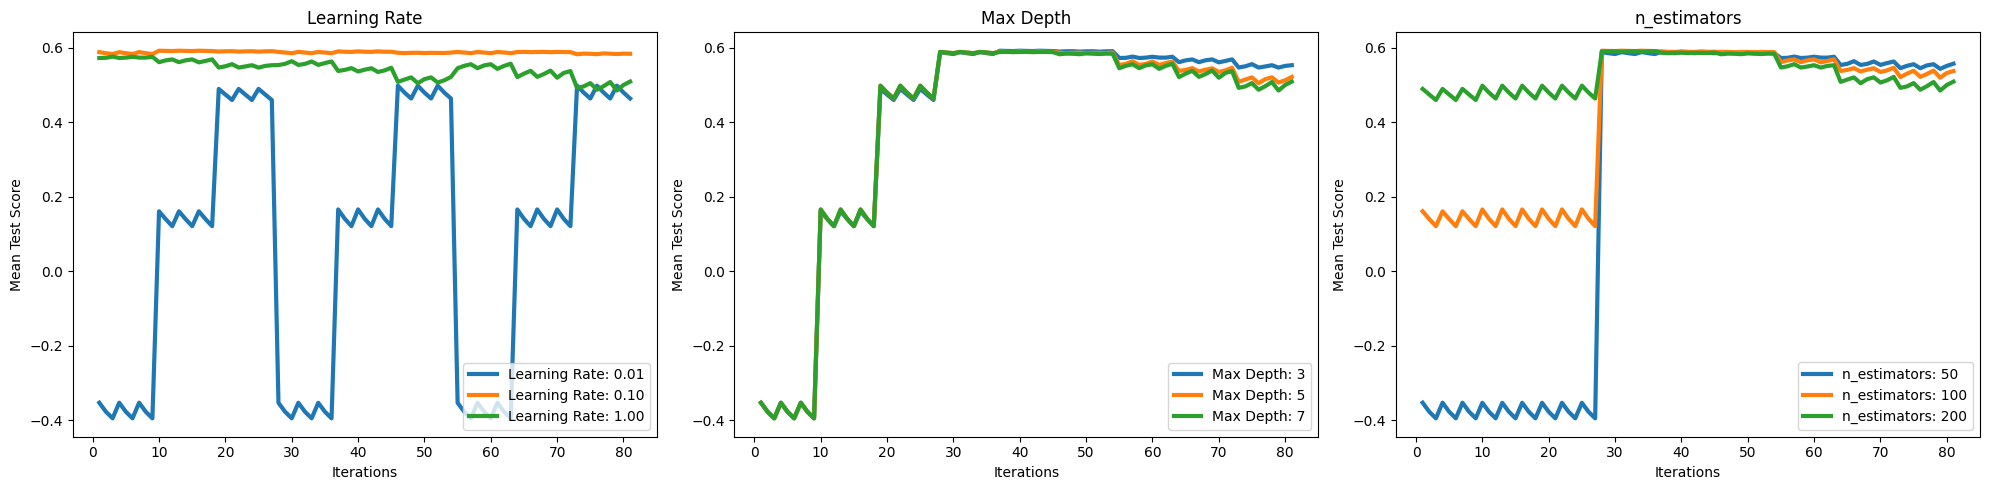

In [95]:
# Plot the graphs of grid search results

# Extract the hyperparameter values and mean test scores from GridSearchCV.cv_results_
results = grid_search.cv_results_
learning_rates = results['param_learning_rate'].data
max_depths = results['param_max_depth'].data
n_estimators = results['param_n_estimators'].data
mean_test_scores = results['mean_test_score']

# Convert the hyperparameter values to numeric arrays
learning_rates = [float(rate) for rate in learning_rates]
max_depths = [int(depth) for depth in max_depths]
n_estimators = [int(n_estimator) for n_estimator in n_estimators]

# Create a dictionary to store the mean test scores for each hyperparameter value
learning_rate_scores = {}
max_depth_scores = {}
n_estimators_scores = {}
for i, rate in enumerate(learning_rates):
    if rate not in learning_rate_scores:
        learning_rate_scores[rate] = []
    learning_rate_scores[rate].append(mean_test_scores[i])
for i, depth in enumerate(max_depths):
    if depth not in max_depth_scores:
        max_depth_scores[depth] = []
    max_depth_scores[depth].append(mean_test_scores[i])
for i, n_estimator in enumerate(n_estimators):
    if n_estimator not in n_estimators_scores:
        n_estimators_scores[n_estimator] = []
    n_estimators_scores[n_estimator].append(mean_test_scores[i])

# Plot line graphs for each hyperparameter value
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for rate, scores in learning_rate_scores.items():
    axs[0].plot(range(1, len(scores) + 1), scores, label=f'Learning Rate: {rate:.2f}', linewidth=3)
for depth, scores in max_depth_scores.items():
    axs[1].plot(range(1, len(scores) + 1), scores, label=f'Max Depth: {depth}', linewidth=3)
for n_estimator, scores in n_estimators_scores.items():
    axs[2].plot(range(1, len(scores) + 1), scores, label=f'n_estimators: {n_estimator}', linewidth=3)
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Test Score')
axs[0].set_title('Learning Rate')
axs[0].legend()
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Mean Test Score')
axs[1].set_title('Max Depth')
axs[1].legend()
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Mean Test Score')
axs[2].set_title('n_estimators')
axs[2].legend()
plt.tight_layout()
plt.show()

##Random Forest

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf= RandomForestRegressor(n_estimators=200,
                          max_depth=8,
                          max_features=11,
                          min_samples_split=100,
                          min_samples_leaf=50,
                          ccp_alpha=0.01)

In [62]:
rf.fit(X_train,Y_train)

RandomForestRegressor(ccp_alpha=0.01, max_depth=8, max_features=11,
                      min_samples_leaf=50, min_samples_split=100,
                      n_estimators=200)

In [63]:
# prediction on training data
training_data_prediction_RF = rf.predict(X_train)

In [64]:
# Random Forest regression model performance on training set

# R squared Value
r2_train_RF = metrics.r2_score(Y_train, training_data_prediction_RF)
print('R Squared value = ', r2_train_RF)

# Mean Absolute Error
MAE_train_RF = metrics.mean_absolute_error(Y_train, training_data_prediction_RF)
print("Mean Absolute Error = ", MAE_train_RF)

# Root Mean Squared Error
MSE_train_RF = metrics.mean_squared_error(Y_train, training_data_prediction_RF)
print("Root Mean Squared Error = ", math.sqrt(MSE_train_RF))

R Squared value =  0.622764835991529
Mean Absolute Error =  726.1010601906145
Root Mean Squared Error =  1033.9376665789814


In [65]:
# prediction on test data
test_data_prediction_RF = rf.predict(X_test)

In [66]:
# Random Forest regression model performance on test set

# R squared Value
r2_test_RF = metrics.r2_score(Y_test, test_data_prediction_RF)
print('R Squared value = ', r2_test_RF)

# Mean Absolute Error
MAE_test_RF = metrics.mean_absolute_error(Y_test, test_data_prediction_RF)
print("Mean Absolute Error = ", MAE_test_RF)

# Root Mean Squared Error
MSE_test_RF = metrics.mean_squared_error(Y_test, test_data_prediction_RF)
print("Root Mean Squared Eror = ", math.sqrt(MSE_test_RF))

R Squared value =  0.6029822833057146
Mean Absolute Error =  768.2506263577341
Root Mean Squared Eror =  1107.977904718086


In [73]:
# Hyperparameter tuning the Random Forest model using grid search

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'ccp_alpha': [0.001, 0.01, 0.1]
}
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [74]:
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'ccp_alpha': 0.001, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.5943927215760126


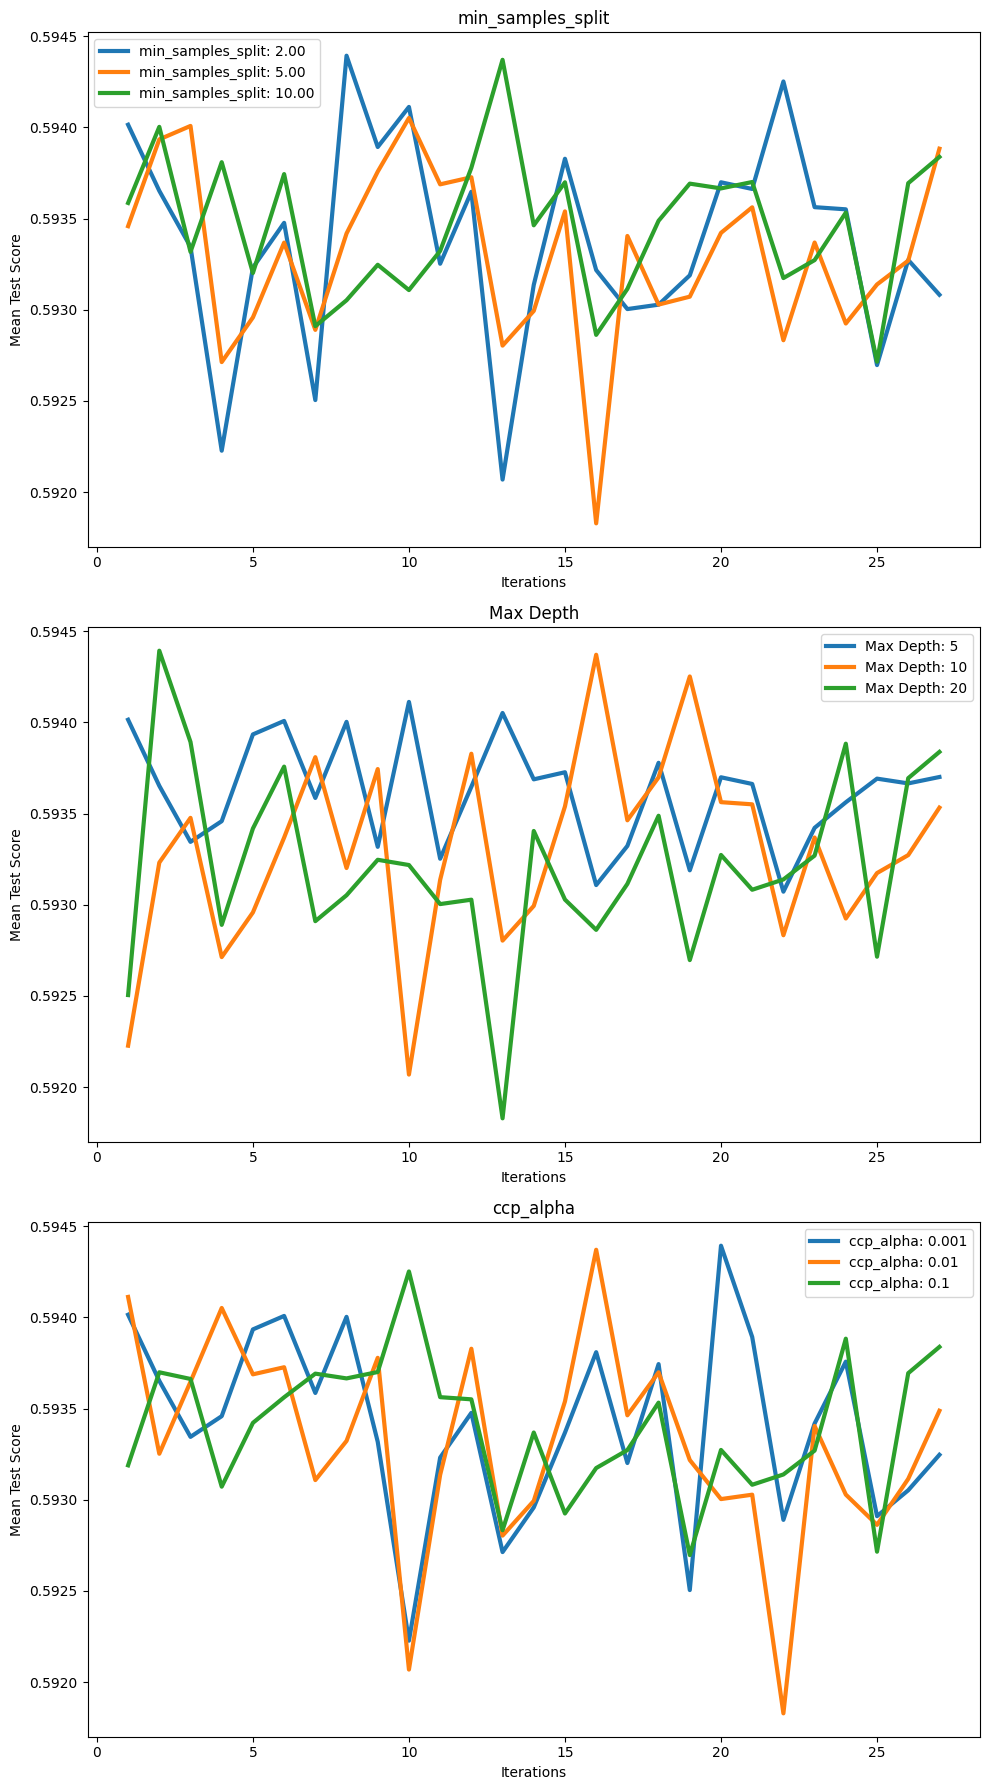

In [92]:
# Extract the hyperparameter values and mean test scores from GridSearchCV.cv_results_
results = grid_search.cv_results_
min_samples_split = results['param_min_samples_split'].data
max_depths = results['param_max_depth'].data
ccp_alphas = results['param_ccp_alpha'].data
mean_test_scores = results['mean_test_score']

# Convert the hyperparameter values to numeric arrays
min_samples_split = [float(rate) for rate in min_samples_split]
max_depths = [int(depth) for depth in max_depths]
ccp_alphas = [float(ccp_alpha) for ccp_alpha in ccp_alphas]

# Create a dictionary to store the mean test scores for each hyperparameter value
min_samples_split_scores = {}
max_depth_scores = {}
ccp_alpha_scores = {}
for i, rate in enumerate(min_samples_split):
    if rate not in min_samples_split_scores:
        min_samples_split_scores[rate] = []
    min_samples_split_scores[rate].append(mean_test_scores[i])
for i, depth in enumerate(max_depths):
    if depth not in max_depth_scores:
        max_depth_scores[depth] = []
    max_depth_scores[depth].append(mean_test_scores[i])
for i, ccp_alpha in enumerate(ccp_alphas):
    if ccp_alpha not in ccp_alpha_scores:
        ccp_alpha_scores[ccp_alpha] = []
    ccp_alpha_scores[ccp_alpha].append(mean_test_scores[i])

# Plot line graphs for each hyperparameter value
fig, axs = plt.subplots(3, 1, figsize=(10, 18))
for rate, scores in min_samples_split_scores.items():
    axs[0].plot(range(1, len(scores) + 1), scores, label=f'min_samples_split: {rate:.2f}', linewidth=3)
for depth, scores in max_depth_scores.items():
    axs[1].plot(range(1, len(scores) + 1), scores, label=f'Max Depth: {depth}', linewidth=3)
for ccp_alpha, scores in ccp_alpha_scores.items():
    axs[2].plot(range(1, len(scores) + 1), scores, label=f'ccp_alpha: {ccp_alpha}', linewidth=3)
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Mean Test Score')
axs[0].set_title('min_samples_split')
axs[0].legend()
axs[1].set_xlabel('Iterations')
axs[1].set_ylabel('Mean Test Score')
axs[1].set_title('Max Depth')
axs[1].legend()
axs[2].set_xlabel('Iterations')
axs[2].set_ylabel('Mean Test Score')
axs[2].set_title('ccp_alpha')
axs[2].legend()
plt.tight_layout()
plt.show()